Height = 4046, Width = 9216


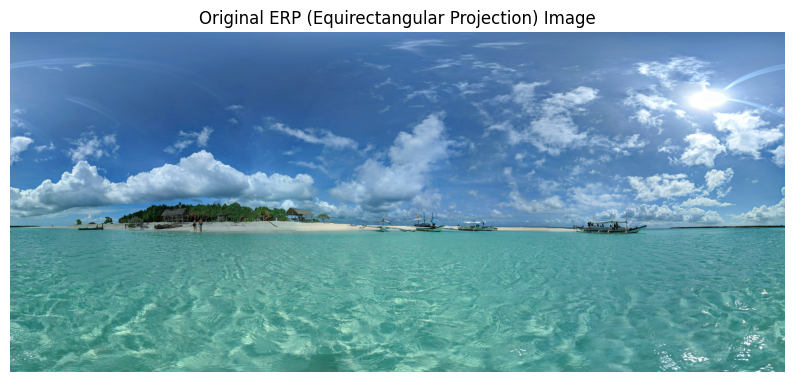

Tile width = 512, Tile height = 450
Reconstructed ERP shape: (4050, 9216, 3)


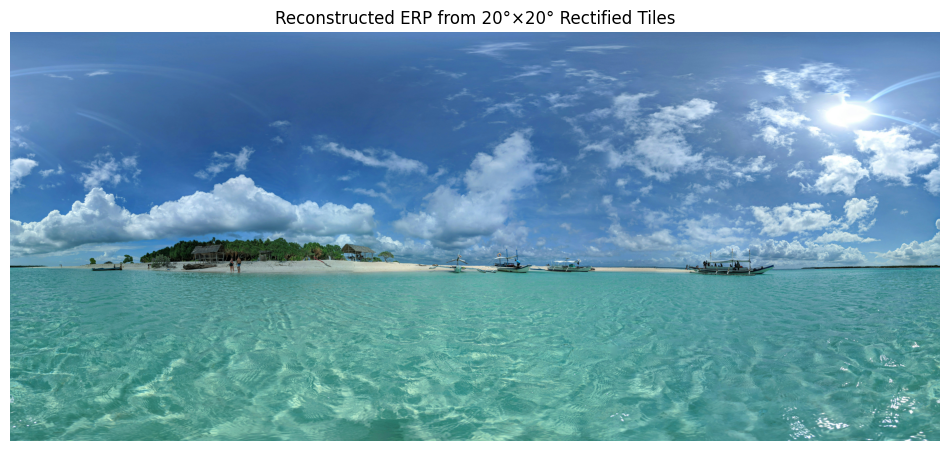

In [2]:
# ============================================================
# 360° ERP Image → Rectified Tile Projection → Saliency Models
# DeepLabV3 | U²-NetP | BASNet
# ============================================================

from IPython.display import Image as ColabImage
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import torch
import torch.nn.functional as F
from torchvision import transforms, models
import os

# ============================================================
# STEP 1: Load ERP Image
# ============================================================

filename = "Ocean360Picture.jpg"
erp = cv2.imread(filename)
erp = cv2.cvtColor(erp, cv2.COLOR_BGR2RGB)
H, W, _ = erp.shape
print(f"Height = {H}, Width = {W}")

plt.figure(figsize=(10, 5))
plt.imshow(erp)
plt.title("Original ERP (Equirectangular Projection) Image")
plt.axis("off")
plt.show()

# ============================================================
# STEP 2: Rectified Tiling (20°×20°)
# ============================================================

widthDegree, heightDegree = 20, 20
num_lon_tiles = int(360 / widthDegree)
num_lat_tiles = int(180 / heightDegree)

tileWidth = int(round(W / num_lon_tiles))
tileHeight = int(round(H / num_lat_tiles))
print(f"Tile width = {tileWidth}, Tile height = {tileHeight}")

finalTiles = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

for lat_i in range(num_lat_tiles):
    lat_max = 90.0 - lat_i * heightDegree
    lat_min = lat_max - heightDegree
    lat_vals = np.linspace(lat_max, lat_min, tileHeight)

    for lon_j in range(num_lon_tiles):
        lon_min = lon_j * widthDegree - 180.0
        lon_max = lon_min + widthDegree
        lon_vals = np.linspace(lon_min, lon_max, tileWidth)

        erp_x_vec = (lon_vals + 180.0) / 360.0 * (W - 1)
        erp_y_vec = (90.0 - lat_vals) / 180.0 * (H - 1)

        map_x = np.tile(erp_x_vec, (tileHeight, 1)).astype(np.float32)
        map_y = np.repeat(erp_y_vec[:, np.newaxis], tileWidth, axis=1).astype(np.float32)

        tile_img = cv2.remap(erp, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)
        finalTiles[lat_i][lon_j] = tile_img

# ============================================================
# STEP 3: Reconstruct ERP from Rectified Tiles
# ============================================================

erp_reconstructed = np.vstack([np.hstack(row) for row in finalTiles])
print("Reconstructed ERP shape:", erp_reconstructed.shape)

plt.figure(figsize=(12, 6))
plt.imshow(erp_reconstructed)
plt.title("Reconstructed ERP from 20°×20° Rectified Tiles")
plt.axis("off")
plt.show()

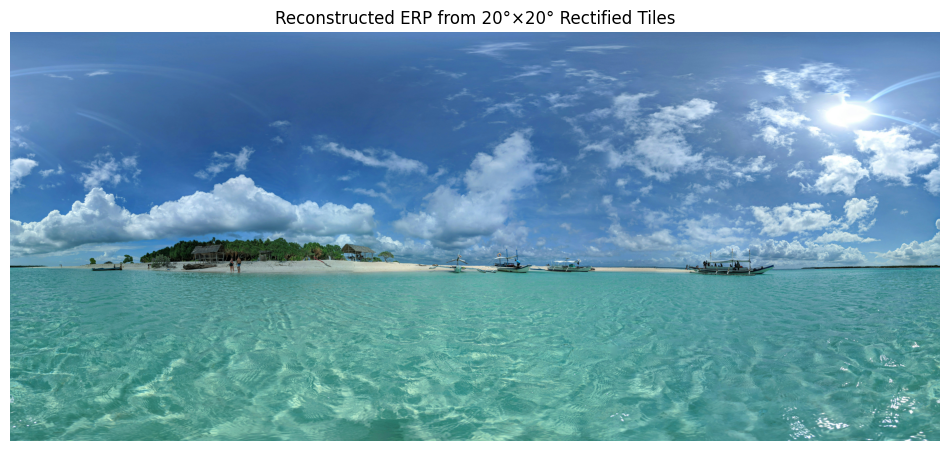

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


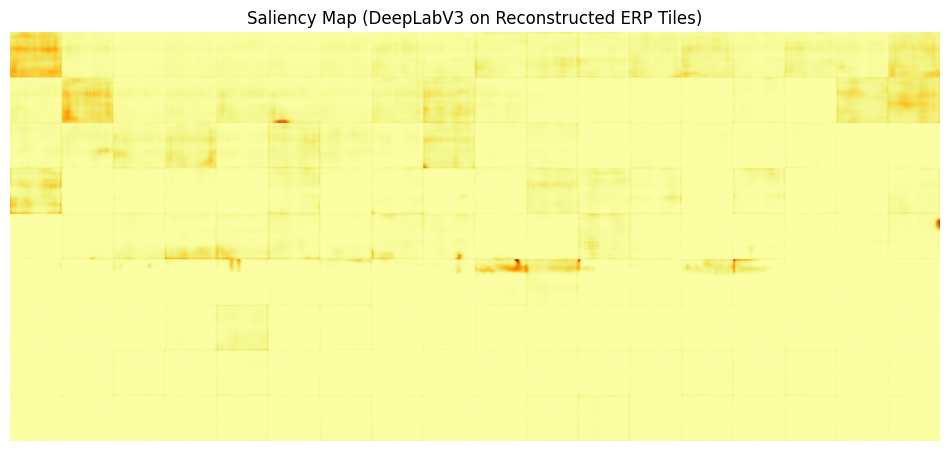

In [ ]:
# ============================================================
# STEP 4: DeepLabV3
# ============================================================

plt.figure(figsize=(12, 6))
plt.imshow(erp_reconstructed)
plt.title("Reconstructed ERP from 20°×20° Rectified Tiles")
plt.axis("off")
plt.show()

deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True).eval()
transform_dl = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

saliencyTiles_dl = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

for lat_i in range(num_lat_tiles):
    for lon_j in range(num_lon_tiles):
        tile_img = finalTiles[lat_i][lon_j]
        if tile_img is None:
            continue
        input_tensor = transform_dl(tile_img).unsqueeze(0)
        with torch.no_grad():
            output = deeplab(input_tensor)["out"][0]
            saliency = torch.sigmoid(output[0]).cpu().numpy()
        saliency_resized = cv2.resize(saliency, (tileWidth, tileHeight))
        saliencyTiles_dl[lat_i][lon_j] = saliency_resized

erp_sal_dl = np.vstack([np.hstack(row) for row in saliencyTiles_dl])
erp_sal_dl = (erp_sal_dl - erp_sal_dl.min()) / (erp_sal_dl.max() - erp_sal_dl.min() + 1e-8)

plt.figure(figsize=(12, 6))
plt.imshow(erp_sal_dl, cmap="inferno")
plt.title("Saliency Map (DeepLabV3 on Reconstructed ERP Tiles)")
plt.axis("off")
plt.show()

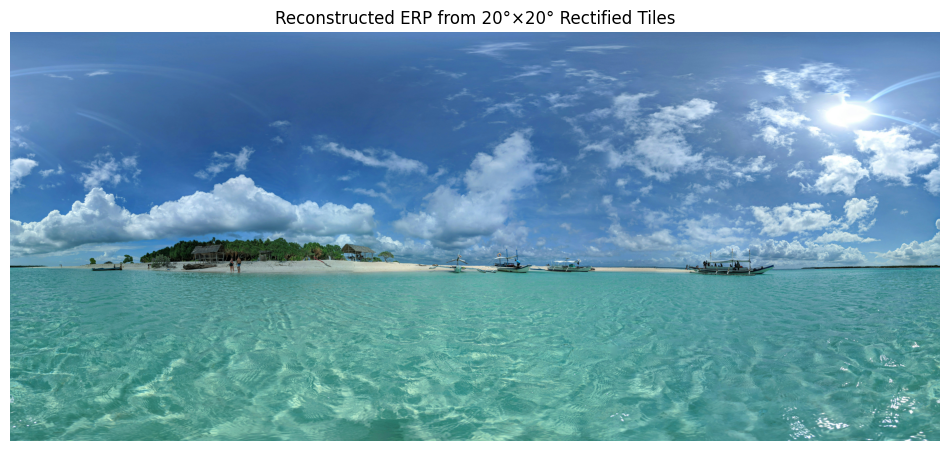

/content/U-2-Net


/content/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


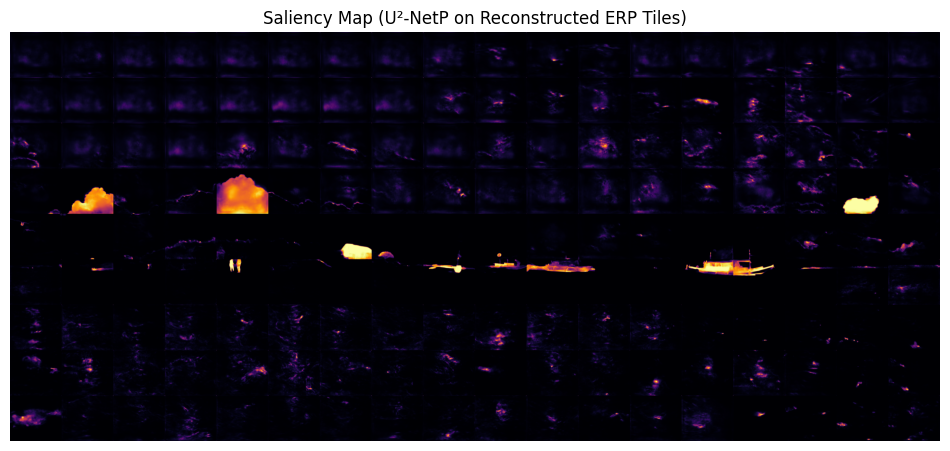

In [ ]:
# ============================================================
# STEP 5: U²-NetP
# ============================================================

plt.figure(figsize=(12, 6))
plt.imshow(erp_reconstructed)
plt.title("Reconstructed ERP from 20°×20° Rectified Tiles")
plt.axis("off")
plt.show()

!pip install -q gdown
!git clone -q https://github.com/xuebinqin/U-2-Net.git
%cd U-2-Net

from model.u2net import U2NETP
!gdown -q 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O u2netp.pth

u2netp = U2NETP(3, 1)
u2netp.load_state_dict(torch.load("u2netp.pth", map_location="cpu"))
u2netp.eval()

transform_u2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

saliencyTiles_u2 = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

for lat_i in range(num_lat_tiles):
    for lon_j in range(num_lon_tiles):
        tile_img = finalTiles[lat_i][lon_j]
        if tile_img is None:
            continue
        input_tensor = transform_u2(tile_img).unsqueeze(0)
        with torch.no_grad():
            d1, *_ = u2netp(input_tensor)
            pred = F.interpolate(d1, size=(tileHeight, tileWidth), mode="bilinear", align_corners=False)
            saliency = pred.squeeze().cpu().numpy()
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
        saliencyTiles_u2[lat_i][lon_j] = saliency

erp_sal_u2 = np.vstack([np.hstack(row) for row in saliencyTiles_u2])
plt.figure(figsize=(12, 6))
plt.imshow(erp_sal_u2, cmap="inferno")
plt.title("Saliency Map (U²-NetP on Reconstructed ERP Tiles)")
plt.axis("off")
plt.show()


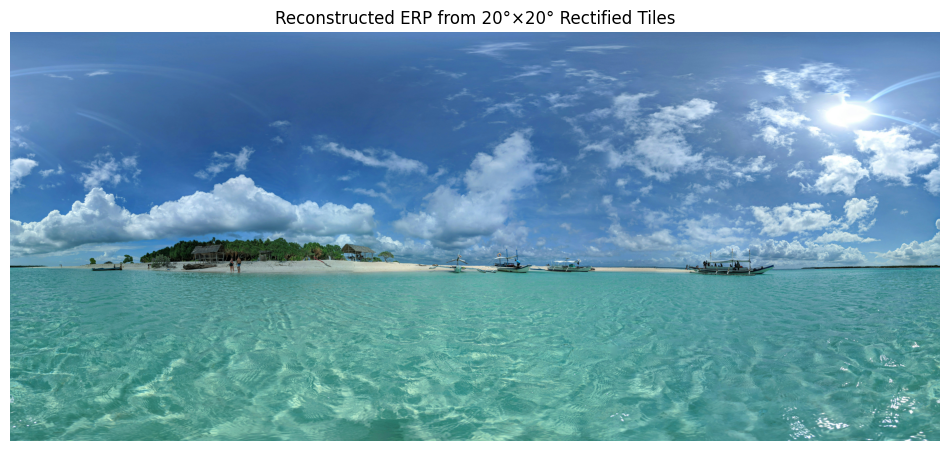

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1303  100  1303    0     0   5984      0 --:--:-- --:--:-- --:--:--  6004
100  332M  100  332M    0     0   206M      0  0:00:01  0:00:01 --:--:--  214M


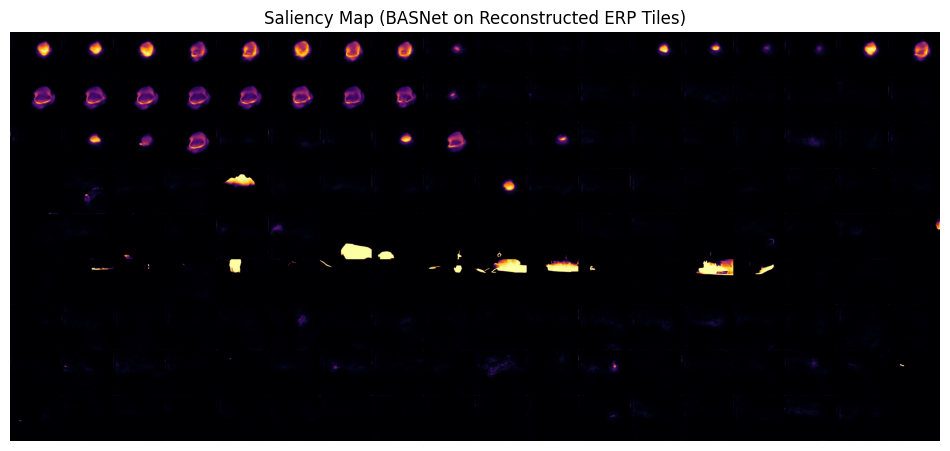

In [6]:
# ============================================================
# STEP 6: BASNet
# ============================================================

plt.figure(figsize=(12, 6))
plt.imshow(erp_reconstructed)
plt.title("Reconstructed ERP from 20°×20° Rectified Tiles")
plt.axis("off")
plt.show()

#!git clone -q https://github.com/xuebinqin/BASNet.git
#from BASNet.model import BASNet
#!gdown -q 1-Yg0cxgrNhHP-016FPdp902BR-kSsA4P -O BASNet.pth

!curl -L -o BASNet.pth "https://huggingface.co/creative-graphic-design/BASNet-checkpoints/resolve/main/basnet.pth"

from BASNet.model import BASNet
import torch

basnet = BASNet(3, 1)
basnet.load_state_dict(torch.load("BASNet.pth", map_location="cpu"))
basnet.eval()

transform_bas = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

saliencyTiles_bas = [[None for _ in range(num_lon_tiles)] for _ in range(num_lat_tiles)]

for lat_i in range(num_lat_tiles):
    for lon_j in range(num_lon_tiles):
        tile_img = finalTiles[lat_i][lon_j]
        if tile_img is None:
            continue
        input_tensor = transform_bas(tile_img).unsqueeze(0)
        with torch.no_grad():
            d1, *_ = basnet(input_tensor)
            pred = F.interpolate(d1, size=(tileHeight, tileWidth), mode="bilinear", align_corners=False)
            saliency = pred.squeeze().cpu().numpy()
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
        saliencyTiles_bas[lat_i][lon_j] = saliency

erp_sal_bas = np.vstack([np.hstack(row) for row in saliencyTiles_bas])
plt.figure(figsize=(12, 6))
plt.imshow(erp_sal_bas, cmap="inferno")
plt.title("Saliency Map (BASNet on Reconstructed ERP Tiles)")
plt.axis("off")
plt.show()